<a href="https://colab.research.google.com/github/debashisdotchatterjee/WDI-Land-Use-Monitoring-via-Hotelling-s-T-2-/blob/main/Hotelling_T%5E2_Monitoring_of_Land_Use.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching IND / AG.LND.AGRI.ZS ...
Fetching IND / AG.LND.FRST.ZS ...
Fetching BRA / AG.LND.AGRI.ZS ...
Fetching BRA / AG.LND.FRST.ZS ...
Fetching ZAF / AG.LND.AGRI.ZS ...
Fetching ZAF / AG.LND.FRST.ZS ...
[saved data] outputs/data/wdi_landuse_cleaned.csv

Preview of cleaned data (first rows)
indicator iso3  year  agri_land_pct  forest_pct
0          BRA  2000      27.317501   65.934359
1          BRA  2001      27.329908   65.461671
2          BRA  2002      27.342315   64.988983
3          BRA  2003      27.354722   64.516295
4          BRA  2004      27.367130   64.043608
5          BRA  2005      27.379537   63.570920
6          BRA  2006      27.392578   63.098232
7          BRA  2007      27.478817   62.625545
8          BRA  2008      27.565056   62.152857
9          BRA  2009      27.651296   61.680169
10         BRA  2010      27.737535   61.207482
11         BRA  2011      27.823774   61.023328
[saved table] outputs/tables/missingness_by_country.csv

Missingness by country (cou

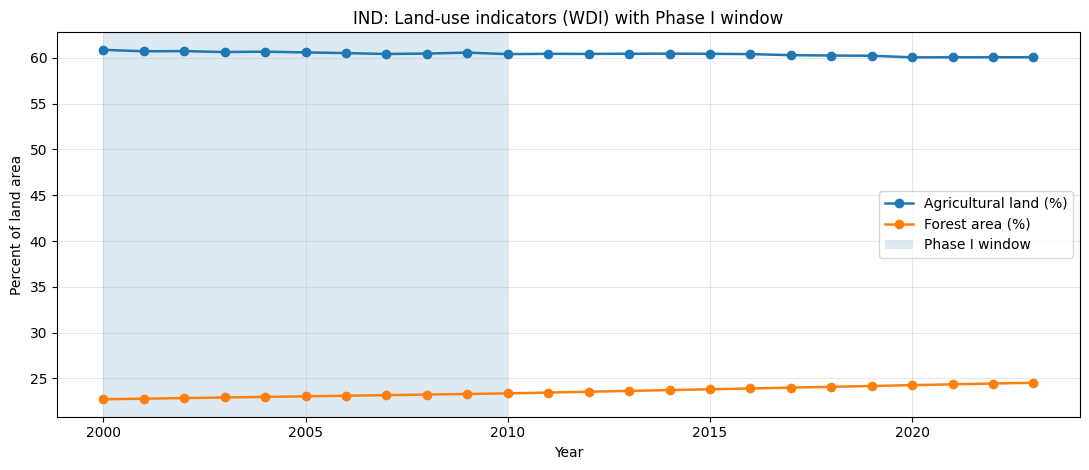

[saved figure] outputs/figures/IND_trajectory_plane.png


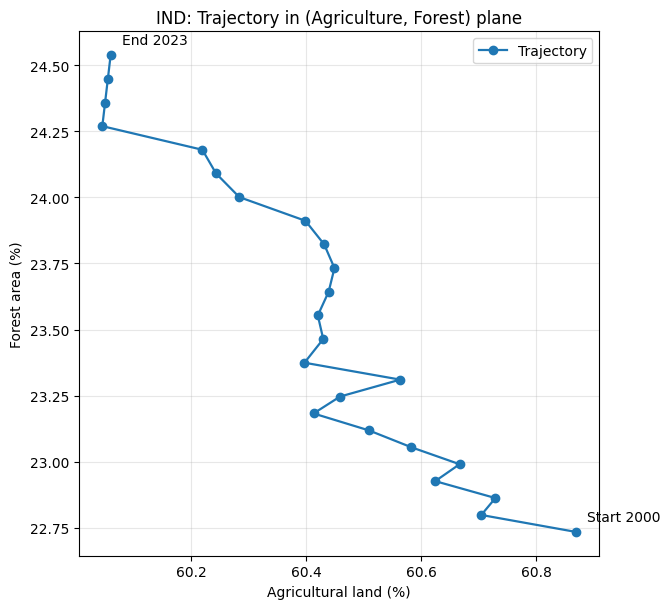

[saved figure] outputs/figures/IND_T2_chart.png


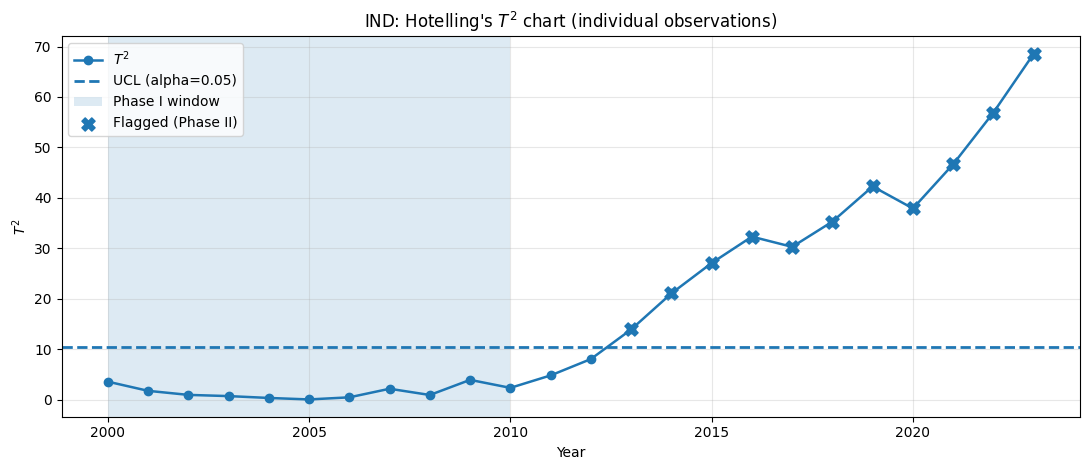

[saved figure] outputs/figures/IND_standardized_space.png


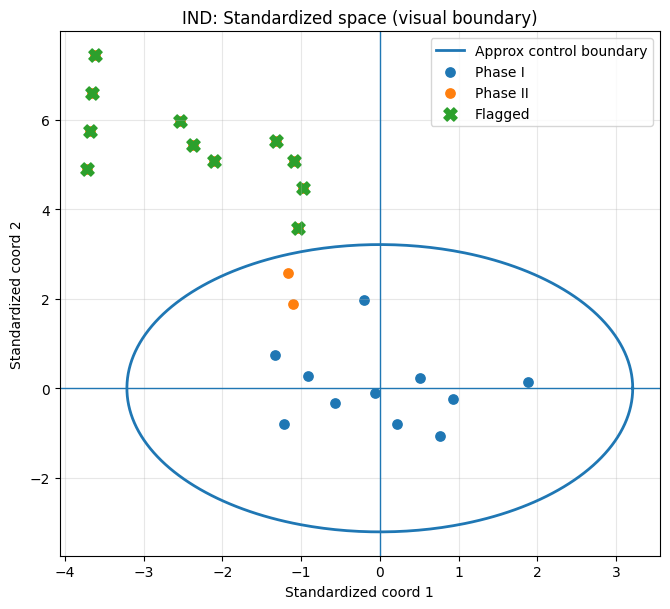

[saved figure] outputs/figures/IND_exceedance_bars.png


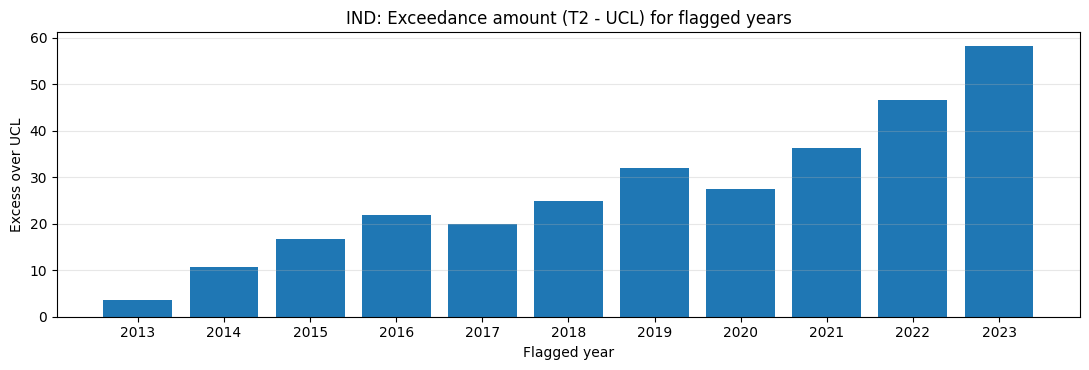

[saved figure] outputs/figures/BRA_timeseries_indicators.png


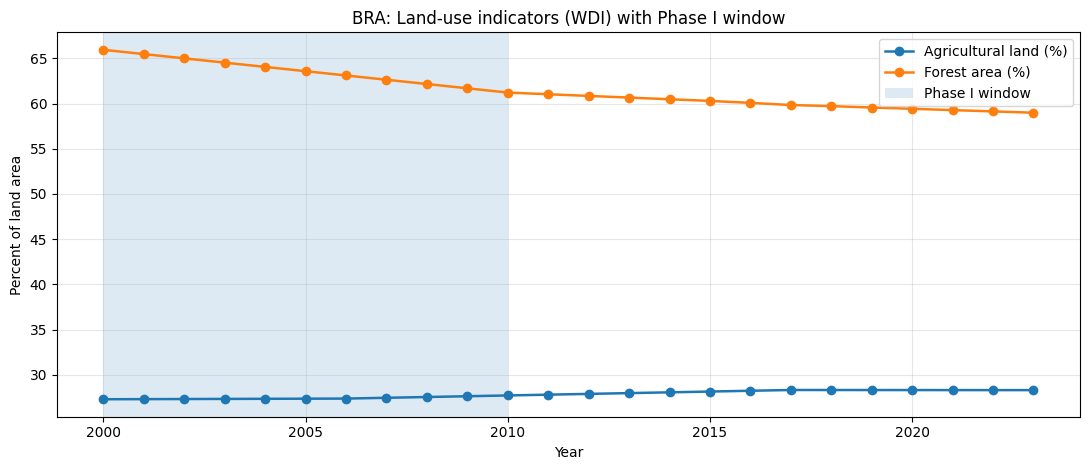

[saved figure] outputs/figures/BRA_trajectory_plane.png


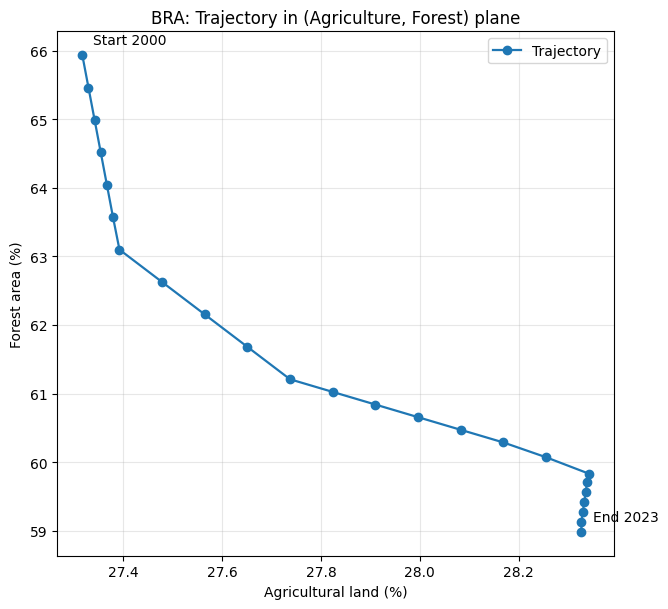

[saved figure] outputs/figures/BRA_T2_chart.png


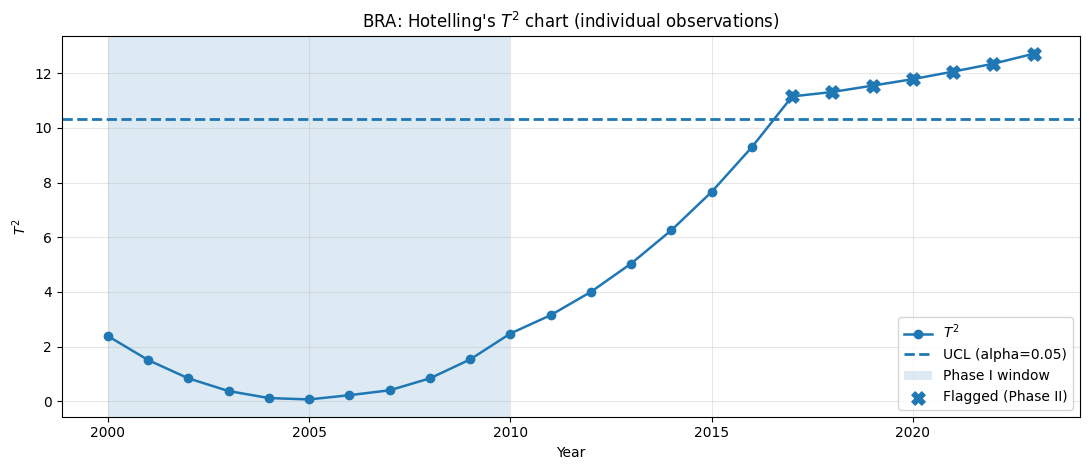

[saved figure] outputs/figures/BRA_standardized_space.png


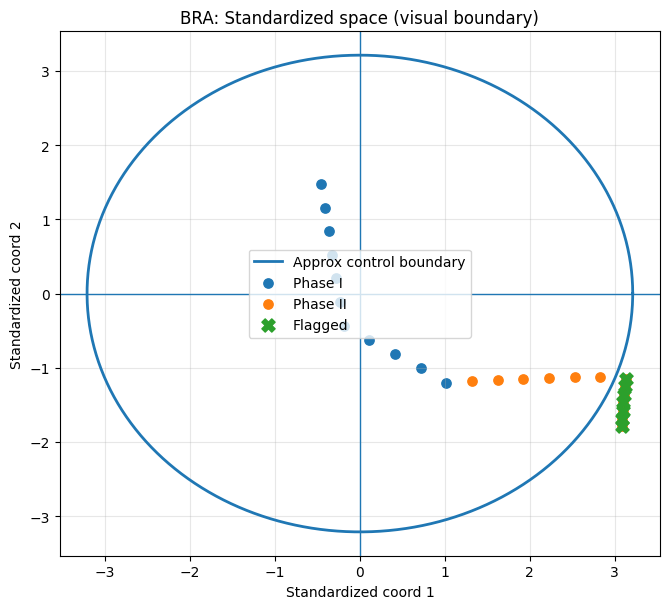

[saved figure] outputs/figures/BRA_exceedance_bars.png


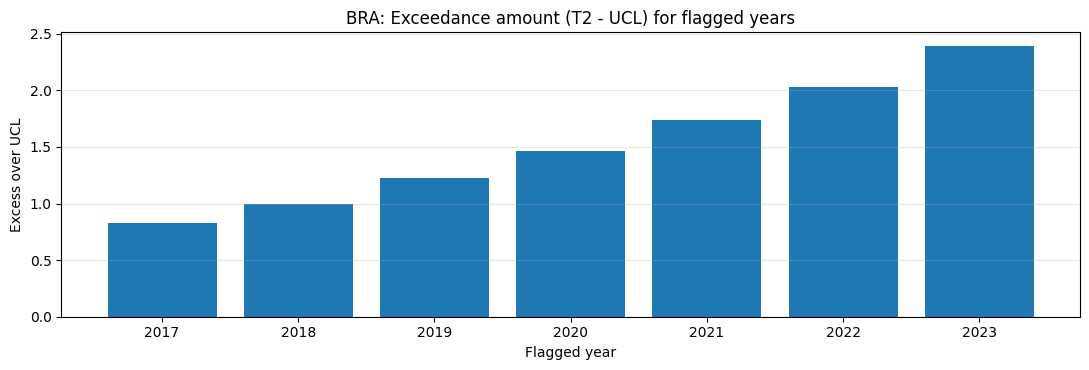

[saved figure] outputs/figures/ZAF_timeseries_indicators.png


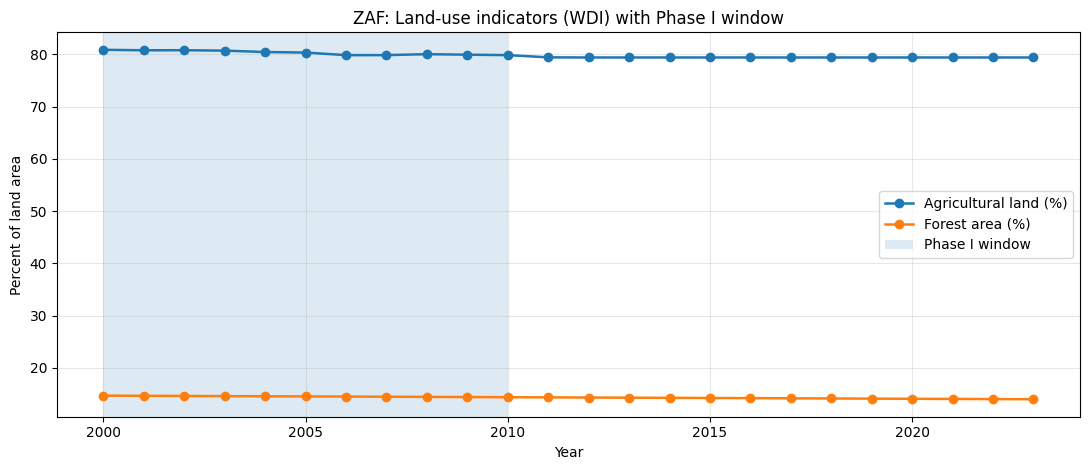

[saved figure] outputs/figures/ZAF_trajectory_plane.png


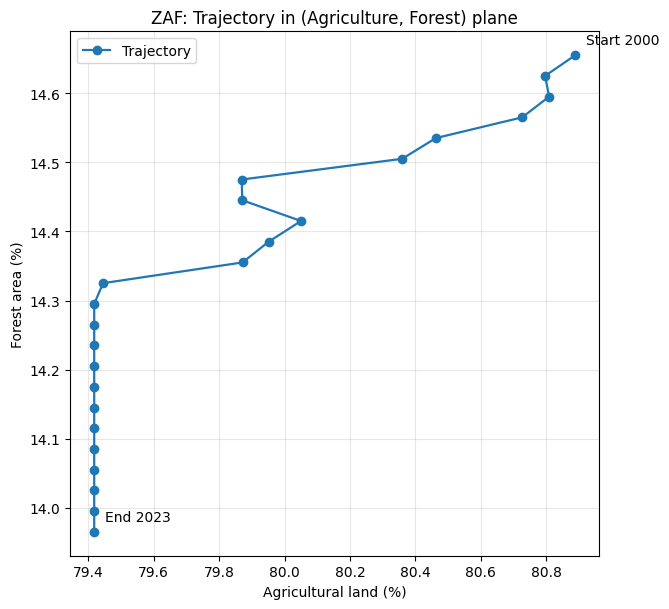

[saved figure] outputs/figures/ZAF_T2_chart.png


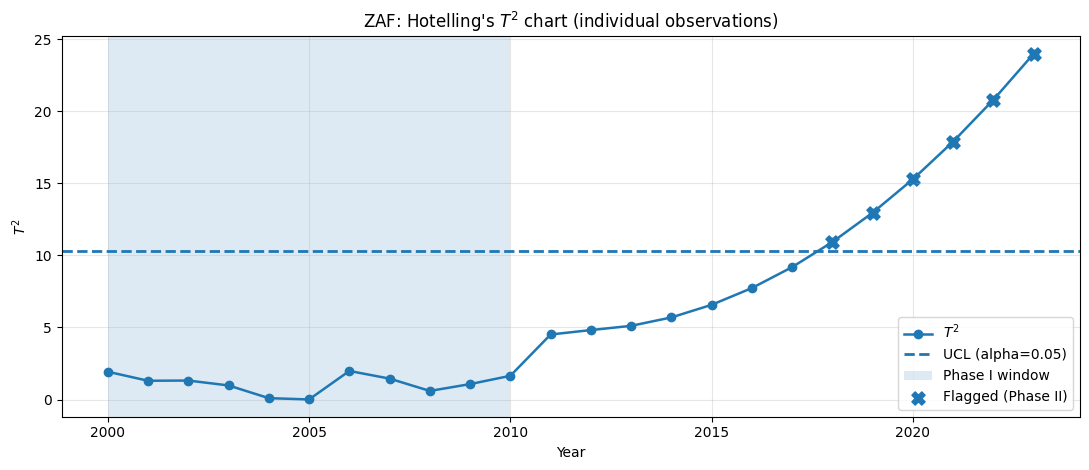

[saved figure] outputs/figures/ZAF_standardized_space.png


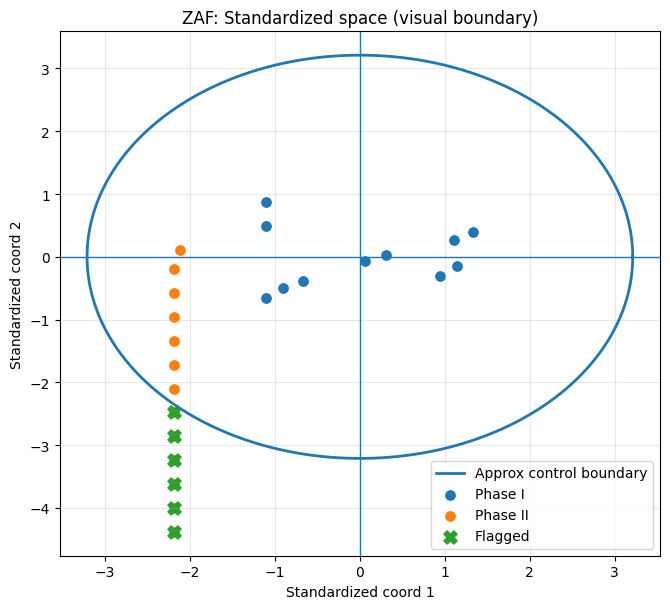

[saved figure] outputs/figures/ZAF_exceedance_bars.png


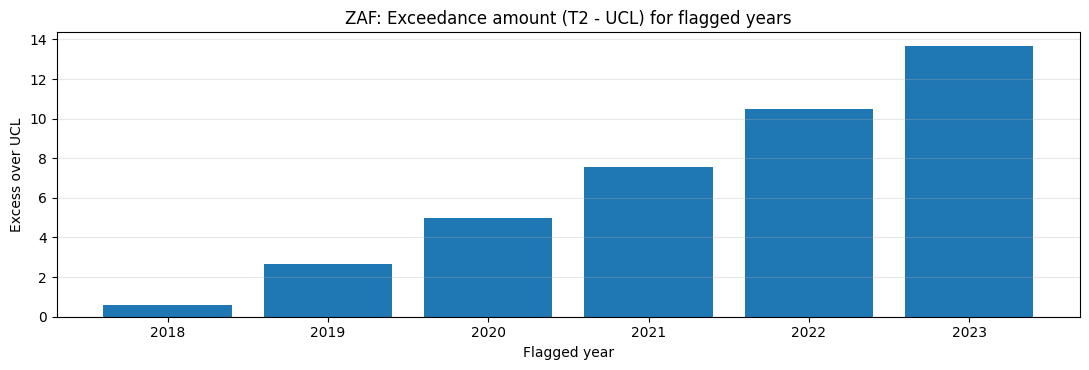


[saved table] outputs/tables/summary_mspc_results.csv
[saved table] outputs/tables/flagged_years.csv

SUMMARY TABLE (copy-ready)
  iso3     PhaseI    PhaseII  m_phase1  p  alpha      UCL_F  PhaseII_n  PhaseII_flags  PhaseII_max_T2  corr_agri_forest_phase1
0  BRA  2000-2010  2011-2023        11  2   0.05  10.318775         13              7       12.711613                -0.911447
1  IND  2000-2010  2011-2023        11  2   0.05  10.318775         13             11       68.575496                -0.896971
2  ZAF  2000-2010  2011-2023        11  2   0.05  10.318775         13              6       23.992729                 0.929831

FLAGGED YEARS TABLE (copy-ready)
   iso3  year         T2        UCL     excess  agri_land_pct  forest_pct  contrib_agri  contrib_forest
0   BRA  2017  11.150091  10.318775   0.831316      28.341114   59.832929      9.819172        1.330918
1   BRA  2018  11.313704  10.318775   0.994929      28.338219   59.708380      9.755685        1.558019
2   BRA  2019  1

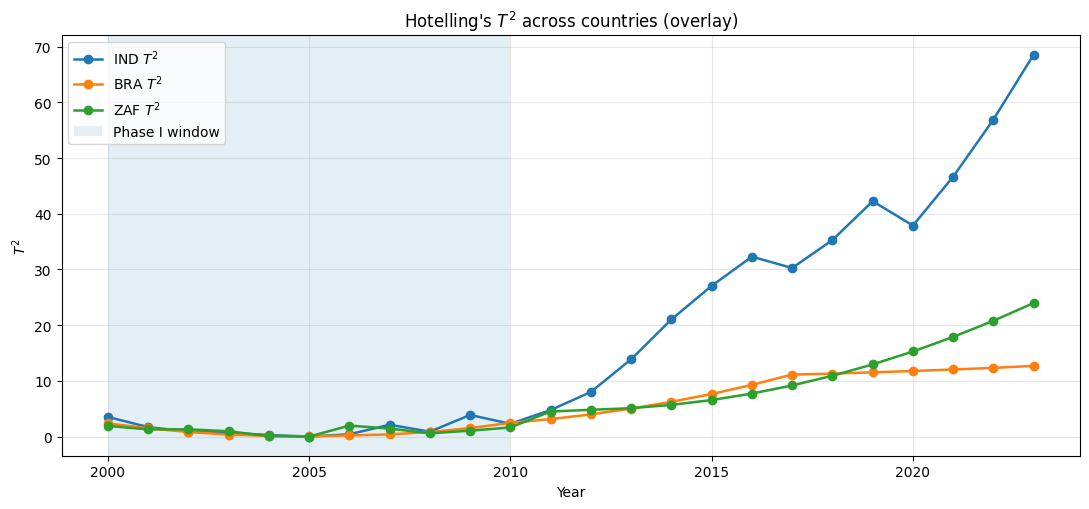

[saved report] outputs/report/REPORT.md

[ZIP READY] outputs/outputs.zip
Download in Colab:
  from google.colab import files; files.download('outputs/outputs.zip')

Directory tree (top-level):
 - data   : outputs/data
 - tables : outputs/tables
 - figures: outputs/figures
 - report : outputs/report
 - cache  : outputs/data/cache_worldbank_json

IND: last 8 observations (copy-ready)
indicator iso3  year  agri_land_pct  forest_pct
40         IND  2016      60.399100   23.911691
41         IND  2017      60.284072   24.001493
42         IND  2018      60.243711   24.090960
43         IND  2019      60.219831   24.180762
44         IND  2020      60.045944   24.270228
45         IND  2021      60.050765   24.359694
46         IND  2022      60.055586   24.449497
47         IND  2023      60.060406   24.539030

BRA: last 8 observations (copy-ready)
indicator iso3  year  agri_land_pct  forest_pct
16         BRA  2016      28.254971   60.071021
17         BRA  2017      28.341114   59.832929


In [2]:
# ============================================================
# Google Colab (ROBUST): MSQC / Hotelling T^2 Monitoring of Land-Use (WDI/FAO)
# Fixes World Bank API timeout by:
#   - using direct requests to the World Bank API (with long timeouts + retries)
#   - chunking by country/indicator and paginating
#   - optional local caching to avoid re-download
#
# Outputs (auto-saved):
#   outputs/
#     data/       -> cleaned CSVs + cached raw JSON
#     tables/     -> summary + flagged-years tables (CSV)
#     figures/    -> many PNG plots
#     report/     -> Markdown report
#     outputs.zip -> zipped bundle
#
# Shows all plots inline + prints copy-ready tables in console.
# ============================================================

# -----------------------------
# 0) Setup
# -----------------------------
import os, sys, math, json, time, zipfile, warnings
from typing import Dict, List, Tuple, Optional

warnings.filterwarnings("ignore")

def ensure(pkgs):
    import importlib, subprocess
    for p in pkgs:
        name = p.split("==")[0].split(">=")[0].split("<=")[0]
        try:
            importlib.import_module(name.replace("-", "_"))
        except Exception:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", p])

ensure([
    "pandas>=2.0",
    "numpy>=1.24",
    "matplotlib>=3.7",
    "scipy>=1.10",
    "requests>=2.31",
])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import f
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

pd.set_option("display.width", 200)
pd.set_option("display.max_columns", 80)
pd.set_option("display.max_rows", 200)

RNG = np.random.default_rng(12345)

# -----------------------------
# 1) Config
# -----------------------------
OUTDIR = "outputs"
DIRS = {
    "data":    os.path.join(OUTDIR, "data"),
    "tables":  os.path.join(OUTDIR, "tables"),
    "figures": os.path.join(OUTDIR, "figures"),
    "report":  os.path.join(OUTDIR, "report"),
    "cache":   os.path.join(OUTDIR, "data", "cache_worldbank_json"),
}
for d in DIRS.values():
    os.makedirs(d, exist_ok=True)

COUNTRIES = ["IND", "BRA", "ZAF"]
INDICATORS = {
    "AG.LND.AGRI.ZS": "agri_land_pct",  # Agricultural land (% of land area)
    "AG.LND.FRST.ZS": "forest_pct",     # Forest area (% of land area)
}

START_YEAR = 2000
END_YEAR = 2023

PHASE1_START = 2000
PHASE1_END   = 2010
PHASE2_START = 2011
PHASE2_END   = 2023

ALPHA = 0.05

# API robustness settings
WB_BASE = "https://api.worldbank.org/v2"
REQUEST_TIMEOUT = (10, 120)   # (connect timeout, read timeout) in seconds
MAX_RETRIES = 6               # total retries
BACKOFF = 0.8                 # exponential backoff base
PER_PAGE = 20000              # years small, but keep huge to avoid pagination
USE_CACHE = True              # set False if you always want fresh download

def savefig(path, dpi=220, tight=True):
    if tight:
        plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[saved figure] {path}")

def print_table(df, title=None, max_rows=200):
    if title:
        print("\n" + "="*len(title))
        print(title)
        print("="*len(title))
    with pd.option_context("display.max_rows", max_rows, "display.max_columns", None):
        print(df)

# -----------------------------
# 2) Robust World Bank API downloader (requests + retries + cache)
# -----------------------------
def make_session() -> requests.Session:
    s = requests.Session()
    retry = Retry(
        total=MAX_RETRIES,
        connect=MAX_RETRIES,
        read=MAX_RETRIES,
        status=MAX_RETRIES,
        backoff_factor=BACKOFF,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
        raise_on_status=False,
        respect_retry_after_header=True,
    )
    adapter = HTTPAdapter(max_retries=retry, pool_connections=20, pool_maxsize=20)
    s.mount("https://", adapter)
    s.mount("http://", adapter)
    s.headers.update({"User-Agent": "Colab-MSPC-HotellingT2/1.0"})
    return s

SESSION = make_session()

def cache_path(country: str, indicator: str, start: int, end: int) -> str:
    fn = f"wb_{country}_{indicator}_{start}_{end}.json"
    return os.path.join(DIRS["cache"], fn)

def wb_fetch_country_indicator(country: str, indicator: str, start: int, end: int,
                               use_cache: bool = True) -> List[dict]:
    """
    Fetches World Bank API data for one country and one indicator.
    Returns list of records (dicts) from JSON.
    Uses cache if enabled.
    """
    cpath = cache_path(country, indicator, start, end)
    if use_cache and os.path.exists(cpath):
        with open(cpath, "r", encoding="utf-8") as f:
            payload = json.load(f)
        return payload

    url = f"{WB_BASE}/country/{country}/indicator/{indicator}"
    params = {
        "format": "json",
        "per_page": PER_PAGE,
        "date": f"{start}:{end}",
    }

    # One call should suffice (per_page huge), but keep a pagination loop just in case.
    all_rows = []
    page = 1
    while True:
        params["page"] = page
        try:
            r = SESSION.get(url, params=params, timeout=REQUEST_TIMEOUT)
        except requests.exceptions.RequestException as e:
            # last-resort wait + retry loop externally
            raise RuntimeError(f"Request failed for {country}-{indicator}: {e}")

        if r.status_code != 200:
            # sometimes WB returns HTML or 50x; retries handled by session, but still check
            raise RuntimeError(f"WB API HTTP {r.status_code} for {country}-{indicator}: {r.text[:250]}")

        data = r.json()
        # data is usually [metadata, rows]
        if not isinstance(data, list) or len(data) < 2:
            # World Bank returns {"message": ...} on some errors
            raise RuntimeError(f"Unexpected JSON for {country}-{indicator}: {str(data)[:250]}")

        meta, rows = data[0], data[1]
        if rows is None:
            rows = []
        all_rows.extend(rows)

        pages = int(meta.get("pages", 1))
        if page >= pages:
            break
        page += 1

    if use_cache:
        with open(cpath, "w", encoding="utf-8") as f:
            json.dump(all_rows, f)
    return all_rows

def build_wdi_dataframe(countries: List[str], indicators: Dict[str, str],
                        start: int, end: int, use_cache: bool = True) -> pd.DataFrame:
    """
    Downloads all requested (country, indicator) and returns a tidy dataframe:
    iso3, year, <indicator columns>
    """
    records = []
    for c in countries:
        for ind_code in indicators.keys():
            print(f"Fetching {c} / {ind_code} ...")
            rows = wb_fetch_country_indicator(c, ind_code, start, end, use_cache=use_cache)
            for rr in rows:
                # rr fields: date, value, countryiso3code etc.
                year_str = rr.get("date", None)
                val = rr.get("value", None)
                if year_str is None:
                    continue
                try:
                    year = int(year_str)
                except Exception:
                    continue
                records.append({
                    "iso3": c,
                    "year": year,
                    "indicator": ind_code,
                    "value": val
                })
            # polite short pause reduces 429 risk
            time.sleep(0.15)

    long = pd.DataFrame.from_records(records)
    if long.empty:
        raise RuntimeError("No data returned from World Bank API. Try later or widen years.")

    # Convert to numeric
    long["value"] = pd.to_numeric(long["value"], errors="coerce")

    wide = (long
            .pivot_table(index=["iso3", "year"], columns="indicator", values="value", aggfunc="mean")
            .reset_index())

    # Rename indicator columns to friendly names
    wide = wide.rename(columns=indicators)

    # Keep requested year range
    wide = wide[(wide["year"] >= start) & (wide["year"] <= end)].copy()
    wide = wide.sort_values(["iso3", "year"]).reset_index(drop=True)
    return wide

# -----------------------------
# 3) Download data (robust)
# -----------------------------
print("Downloading WDI data via robust World Bank API client (requests + retries + cache)...")
df = build_wdi_dataframe(COUNTRIES, INDICATORS, START_YEAR, END_YEAR, use_cache=USE_CACHE)

# Save cleaned (raw-wide) data
data_path = os.path.join(DIRS["data"], "wdi_landuse_cleaned.csv")
df.to_csv(data_path, index=False)
print(f"[saved data] {data_path}")

print_table(df.head(12), "Preview of cleaned data (first rows)")

# Missingness table
miss = (df.groupby("iso3")[["agri_land_pct", "forest_pct"]]
        .apply(lambda g: g.isna().sum())
        .rename(columns={"agri_land_pct": "missing_agri", "forest_pct": "missing_forest"}))
miss_path = os.path.join(DIRS["tables"], "missingness_by_country.csv")
miss.to_csv(miss_path)
print(f"[saved table] {miss_path}")
print_table(miss, "Missingness by country (counts)")

# Drop rows with missing either variable (simple, explicit)
df0 = df.dropna(subset=["agri_land_pct", "forest_pct"]).copy()

# -----------------------------
# 4) MSPC / Hotelling T^2 functions
# -----------------------------
def hotelling_T2_individual(X: np.ndarray, mean: np.ndarray, Sinv: np.ndarray) -> np.ndarray:
    D = X - mean.reshape(1, -1)
    return np.einsum("ni,ij,nj->n", D, Sinv, D)

def UCL_T2_phaseII_F(m: int, p: int, alpha: float) -> float:
    if m <= p:
        raise ValueError(f"Need m>p for UCL_F. Got m={m}, p={p}")
    q = f.ppf(1 - alpha, dfn=p, dfd=m - p)
    return (p * (m + 1) * (m - 1) / (m * (m - p))) * q

def robust_cov_shrinkage(S: np.ndarray, shrink: float = 0.05) -> np.ndarray:
    p = S.shape[0]
    lam = np.trace(S) / p
    return (1 - shrink) * S + shrink * lam * np.eye(p)

def standardized_contributions(x: np.ndarray, mean: np.ndarray, S: np.ndarray, labels: List[str]) -> pd.Series:
    """
    z = L^{-1}(x-mean), L = chol(S)
    contributions = z^2
    """
    L = np.linalg.cholesky(S)
    z = np.linalg.solve(L, (x - mean))
    contrib = z**2
    return pd.Series(contrib, index=[f"contrib_{lab}" for lab in labels])

# -----------------------------
# 5) Run MSPC per country + make many plots/tables
# -----------------------------
labels = ["agri_land_pct", "forest_pct"]
results_rows = []
flags_rows = []
all_series = []

for iso3 in COUNTRIES:
    g = df0[df0["iso3"] == iso3].sort_values("year").copy()
    if g.empty:
        print(f"[WARN] {iso3}: no complete cases after dropping missing.")
        continue

    # Save per-country cleaned data
    cpath = os.path.join(DIRS["data"], f"{iso3}_clean.csv")
    g.to_csv(cpath, index=False)

    # Phase windows
    phase1 = g[(g["year"] >= PHASE1_START) & (g["year"] <= PHASE1_END)].copy()
    phase2 = g[(g["year"] >= PHASE2_START) & (g["year"] <= PHASE2_END)].copy()

    X1 = phase1[labels].to_numpy(float)
    X2 = phase2[labels].to_numpy(float)

    m, p = X1.shape[0], X1.shape[1]
    if m < p + 2:
        print(f"\n[WARN] {iso3}: too few Phase I points m={m}. Widen Phase I window.")
        continue

    mean1 = X1.mean(axis=0)
    S1 = np.cov(X1.T, ddof=1)
    S1s = robust_cov_shrinkage(S1, shrink=0.05)
    Sinv = np.linalg.inv(S1s)

    ucl = UCL_T2_phaseII_F(m=m, p=p, alpha=ALPHA)

    T2_1 = hotelling_T2_individual(X1, mean1, Sinv)
    T2_2 = hotelling_T2_individual(X2, mean1, Sinv)

    phase1 = phase1.assign(T2=T2_1, phase="Phase I")
    phase2 = phase2.assign(T2=T2_2, phase="Phase II")

    series = pd.concat([phase1, phase2], ignore_index=True)
    series["UCL"] = ucl
    all_series.append(series)

    # Flags
    flags = phase2[phase2["T2"] > ucl].copy()
    flags["excess"] = flags["T2"] - ucl

    # Contributions for flags (based on standardized coords using S1s)
    if not flags.empty:
        contribs = []
        for _, rr in flags.iterrows():
            x = rr[labels].to_numpy(float)
            contribs.append(standardized_contributions(x, mean1, S1s, labels))
        flags = pd.concat([flags.reset_index(drop=True), pd.DataFrame(contribs).reset_index(drop=True)], axis=1)

        for _, rr in flags.iterrows():
            flags_rows.append({
                "iso3": iso3,
                "year": int(rr["year"]),
                "T2": float(rr["T2"]),
                "UCL": float(ucl),
                "excess": float(rr["excess"]),
                "agri_land_pct": float(rr["agri_land_pct"]),
                "forest_pct": float(rr["forest_pct"]),
                "contrib_agri": float(rr.get("contrib_agri_land_pct", np.nan)),
                "contrib_forest": float(rr.get("contrib_forest_pct", np.nan)),
            })

    # Summary row
    results_rows.append({
        "iso3": iso3,
        "PhaseI": f"{PHASE1_START}-{PHASE1_END}",
        "PhaseII": f"{PHASE2_START}-{PHASE2_END}",
        "m_phase1": int(m),
        "p": int(p),
        "alpha": float(ALPHA),
        "UCL_F": float(ucl),
        "PhaseII_n": int(X2.shape[0]),
        "PhaseII_flags": int(flags.shape[0]),
        "PhaseII_max_T2": float(np.max(T2_2)) if len(T2_2) else np.nan,
        "corr_agri_forest_phase1": float(np.corrcoef(X1[:,0], X1[:,1])[0,1]) if m >= 2 else np.nan,
    })

    # -------------------------
    # PLOTS (many, all saved + shown)
    # -------------------------

    # (P1) Indicator time series
    plt.figure(figsize=(11, 4.8))
    plt.plot(g["year"], g["agri_land_pct"], marker="o", linewidth=1.8, label="Agricultural land (%)")
    plt.plot(g["year"], g["forest_pct"], marker="o", linewidth=1.8, label="Forest area (%)")
    plt.axvspan(PHASE1_START, PHASE1_END, alpha=0.15, label="Phase I window")
    plt.title(f"{iso3}: Land-use indicators (WDI) with Phase I window")
    plt.xlabel("Year"); plt.ylabel("Percent of land area")
    plt.grid(True, alpha=0.3); plt.legend()
    savefig(os.path.join(DIRS["figures"], f"{iso3}_timeseries_indicators.png"))
    plt.show()

    # (P2) Scatter with trajectory line
    plt.figure(figsize=(6.8, 6.2))
    plt.plot(g["agri_land_pct"], g["forest_pct"], marker="o", linewidth=1.6, label="Trajectory")
    plt.annotate(f"Start {int(g['year'].min())}", (g["agri_land_pct"].iloc[0], g["forest_pct"].iloc[0]),
                 textcoords="offset points", xytext=(8,8))
    plt.annotate(f"End {int(g['year'].max())}", (g["agri_land_pct"].iloc[-1], g["forest_pct"].iloc[-1]),
                 textcoords="offset points", xytext=(8,8))
    plt.title(f"{iso3}: Trajectory in (Agriculture, Forest) plane")
    plt.xlabel("Agricultural land (%)"); plt.ylabel("Forest area (%)")
    plt.grid(True, alpha=0.3); plt.legend()
    savefig(os.path.join(DIRS["figures"], f"{iso3}_trajectory_plane.png"))
    plt.show()

    # (P3) T^2 chart with UCL and flags
    plt.figure(figsize=(11, 4.8))
    plt.plot(series["year"], series["T2"], marker="o", linewidth=1.8, label=r"$T^2$")
    plt.axhline(ucl, linestyle="--", linewidth=2, label=f"UCL (alpha={ALPHA:g})")
    plt.axvspan(PHASE1_START, PHASE1_END, alpha=0.15, label="Phase I window")
    if not flags.empty:
        plt.scatter(flags["year"], flags["T2"], s=90, marker="X", label="Flagged (Phase II)")
    plt.title(f"{iso3}: Hotelling's $T^2$ chart (individual observations)")
    plt.xlabel("Year"); plt.ylabel(r"$T^2$")
    plt.grid(True, alpha=0.3); plt.legend()
    savefig(os.path.join(DIRS["figures"], f"{iso3}_T2_chart.png"))
    plt.show()

    # (P4) Standardized-space boundary (approx) using chol(S1s)
    L = np.linalg.cholesky(S1s)
    Z_all = np.vstack([np.linalg.solve(L, (x - mean1)) for x in g[labels].to_numpy(float)])
    Z1 = np.vstack([np.linalg.solve(L, (x - mean1)) for x in X1])
    Z2 = np.vstack([np.linalg.solve(L, (x - mean1)) for x in X2])

    r = math.sqrt(ucl)
    th = np.linspace(0, 2*np.pi, 400)
    circ_x, circ_y = r*np.cos(th), r*np.sin(th)

    plt.figure(figsize=(6.8, 6.2))
    plt.plot(circ_x, circ_y, linewidth=2, label="Approx control boundary")
    plt.scatter(Z1[:,0], Z1[:,1], s=45, label="Phase I")
    plt.scatter(Z2[:,0], Z2[:,1], s=45, label="Phase II")
    if not flags.empty:
        Zf = np.vstack([np.linalg.solve(L, (rr[labels].to_numpy(float) - mean1)) for _, rr in flags.iterrows()])
        plt.scatter(Zf[:,0], Zf[:,1], s=90, marker="X", label="Flagged")
    plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
    plt.title(f"{iso3}: Standardized space (visual boundary)")
    plt.xlabel("Standardized coord 1"); plt.ylabel("Standardized coord 2")
    plt.grid(True, alpha=0.3); plt.legend()
    savefig(os.path.join(DIRS["figures"], f"{iso3}_standardized_space.png"))
    plt.show()

    # (P5) Phase II T2 exceedance bar (if any flags)
    plt.figure(figsize=(11, 3.8))
    if flags.empty:
        plt.text(0.5, 0.5, f"{iso3}: No Phase II exceedances at alpha={ALPHA}", ha="center", va="center")
        plt.axis("off")
    else:
        plt.bar(flags["year"].astype(int).astype(str), flags["excess"])
        plt.title(f"{iso3}: Exceedance amount (T2 - UCL) for flagged years")
        plt.xlabel("Flagged year"); plt.ylabel("Excess over UCL")
        plt.grid(True, axis="y", alpha=0.3)
    savefig(os.path.join(DIRS["figures"], f"{iso3}_exceedance_bars.png"))
    plt.show()

# -----------------------------
# 6) Save tables + combined series
# -----------------------------
summary = pd.DataFrame(results_rows).sort_values("iso3").reset_index(drop=True)
flags_df = pd.DataFrame(flags_rows).sort_values(["iso3", "year"]).reset_index(drop=True)

summary_path = os.path.join(DIRS["tables"], "summary_mspc_results.csv")
flags_path   = os.path.join(DIRS["tables"], "flagged_years.csv")
summary.to_csv(summary_path, index=False)
flags_df.to_csv(flags_path, index=False)

print(f"\n[saved table] {summary_path}")
print(f"[saved table] {flags_path}")

print_table(summary, "SUMMARY TABLE (copy-ready)")
print_table(flags_df if len(flags_df) else pd.DataFrame({"note":["No Phase II flags at this alpha / phase split."]}),
            "FLAGGED YEARS TABLE (copy-ready)")

# Combined time series
if len(all_series):
    series_all = pd.concat(all_series, ignore_index=True)
    series_path = os.path.join(DIRS["data"], "T2_timeseries_all_countries.csv")
    series_all.to_csv(series_path, index=False)
    print(f"[saved data] {series_path}")

    # Overlay T2 plot across countries
    plt.figure(figsize=(11, 5.2))
    for iso3 in COUNTRIES:
        s = series_all[series_all["iso3"] == iso3].sort_values("year")
        if len(s) == 0:
            continue
        plt.plot(s["year"], s["T2"], marker="o", linewidth=1.8, label=f"{iso3} $T^2$")
    plt.axvspan(PHASE1_START, PHASE1_END, alpha=0.12, label="Phase I window")
    plt.title("Hotelling's $T^2$ across countries (overlay)")
    plt.xlabel("Year"); plt.ylabel(r"$T^2$")
    plt.grid(True, alpha=0.3); plt.legend()
    savefig(os.path.join(DIRS["figures"], "ALL_overlay_T2.png"))
    plt.show()

# -----------------------------
# 7) Simple report
# -----------------------------
report_md = os.path.join(DIRS["report"], "REPORT.md")
with open(report_md, "w", encoding="utf-8") as f:
    f.write("# MSQC / Hotelling T^2 Monitoring of Land-Use (WDI)\n\n")
    f.write(f"- Countries: {', '.join(COUNTRIES)}\n")
    f.write(f"- Years: {START_YEAR}–{END_YEAR}\n")
    f.write(f"- Phase I: {PHASE1_START}–{PHASE1_END}\n")
    f.write(f"- Phase II: {PHASE2_START}–{PHASE2_END}\n")
    f.write(f"- Alpha: {ALPHA}\n\n")
    f.write("## Files\n")
    f.write("- data/wdi_landuse_cleaned.csv\n")
    f.write("- data/T2_timeseries_all_countries.csv\n")
    f.write("- tables/summary_mspc_results.csv\n")
    f.write("- tables/flagged_years.csv\n")
    f.write("- figures/*.png\n\n")
    f.write("## Notes\n")
    f.write("Data fetched from the World Bank API with retries, long timeouts, and caching.\n")
print(f"[saved report] {report_md}")

# -----------------------------
# 8) Zip outputs
# -----------------------------
zip_path = os.path.join(OUTDIR, "outputs.zip")
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for root, _, files in os.walk(OUTDIR):
        for fn in files:
            if fn.endswith(".zip"):
                continue
            full = os.path.join(root, fn)
            arc = os.path.relpath(full, OUTDIR)
            z.write(full, arcname=arc)

print(f"\n[ZIP READY] {zip_path}")
print("Download in Colab:")
print("  from google.colab import files; files.download('outputs/outputs.zip')")

# -----------------------------
# 9) Quick directory listing
# -----------------------------
print("\nDirectory tree (top-level):")
for k, v in DIRS.items():
    print(f" - {k:7s}: {v}")

# Print last rows per country for quick copy
for iso3 in COUNTRIES:
    g = df0[df0["iso3"] == iso3].sort_values("year").copy()
    if len(g) == 0:
        continue
    print_table(g.tail(8), f"{iso3}: last 8 observations (copy-ready)")
